# Chest Disesase Detection & Classification

Dataset has images that belong to 4 classes

# Importing Key Libraries and Datasets

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import layers,optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D,Dropout

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False)

In [ ]:
# Specifying training data directory

XRay_Directory = '/content/drive/MyDrive/Tutorial/Tensorflow/4. Operations Department/Dataset'

#List the folders in the directory

os.listdir(XRay_Directory)

['1', '0', '3', '2']

In [ ]:
# Using image generator to generate tensor images data and normalize them.
# Using 20% of data for Cross-Validation

image_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

In [ ]:
from re import X
# Generating batches of 40 images.
# We have total number of images = 133 x 4 = 532 images
# For training 80% (428) and validation 20% (104) of images.
# We'll perform shuffling and resizing

train_generator = image_generator.flow_from_directory(batch_size=40,
                                                      directory = XRay_Directory,
                                                      shuffle=True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='training'
                                                      )

Found 428 images belonging to 4 classes.


In [ ]:
# Validation image generator
validation_generator = image_generator.flow_from_directory(batch_size=40,
                                                      directory = XRay_Directory,
                                                      shuffle=True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='validation'
                                                      )

Found 104 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels

!pip install pillow

train_images, train_labels = next(train_generator)
train_labels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]],

In [ ]:
# Labels Translator

label_names = {0:'Covid-19', 1:'Normal', 2:'Viral Pneumonia', 3:'Bacterial Pneumonia'}
train_images.shape

(40, 256, 256, 3)

# Data Visualization

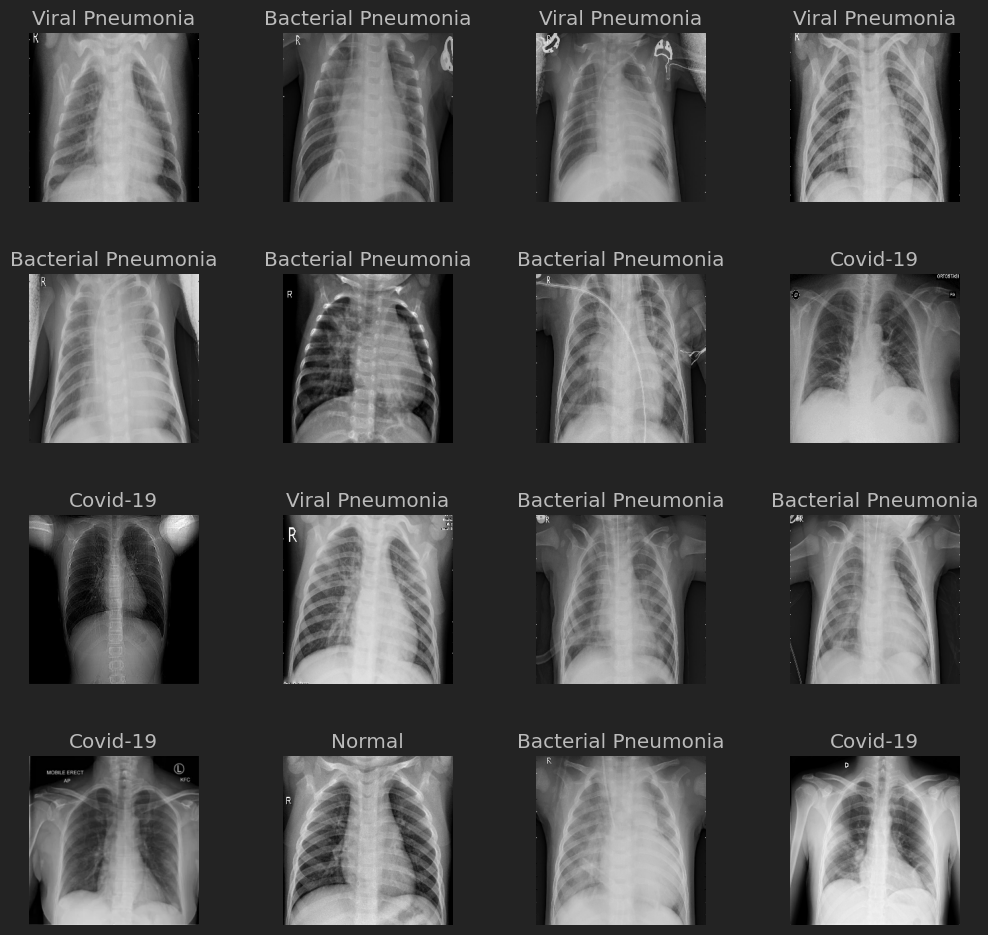

In [ ]:
# Creating a grid of 16 images along with their corresponding labels

L = 4
W = 4

fig, axes = plt.subplots(L,W, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])]) # np.argmax = Returns the indices of the maximum values along an axis
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

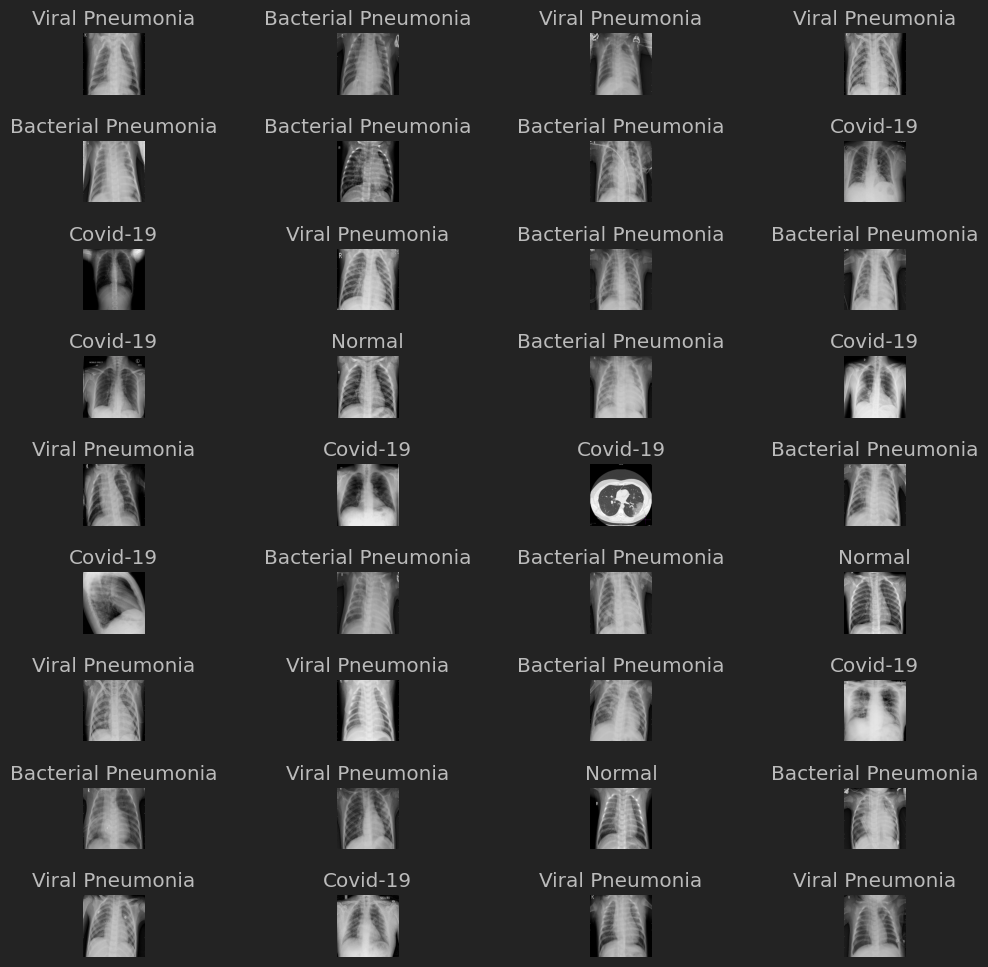

In [ ]:
L = 9
W = 4

fig, axes = plt.subplots(L,W, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])]) # np.argmax = Returns the indices of the maximum values along an axis
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.75)

## Other Information for learning purpose

1. The first CNN layers are used to extract high level general features.
2. Last couple of layers are used to perform classification (on specific task).
3. Local respective fields scan the image first searching for simple shapes such as edges/lines
4. These edges are then picked up by subsequent layers to form more complex features

**Vanishing Gradient Problem:**
- As CNNs grow deeper, vanishing gradient tend to occur which negatively impact network performance.
- Vanishing gradient problem occurs when gradient is backpropagated to early layers for updating weights/bias whihc results in a very small gradient.
- Residual Neural Network includes "skip-connection" features which enables training of 152 layers without vanishing gradient issues.

**In Transfer Learning, why do we keep (freeze) 1st (early) layers and retrain deeper layers?**

1. 1st CNN layers are used to extract high level general features.
2. Last couple of layers are used to perform classification (on a specific task)
3. We copy the first trained layers (base model) & then we add a new custom layers in the output to perform classification on a specific new task

# Importing Model with Pretrained Weights

In [ ]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
basemodel.summary()

In [ ]:
#Freezing the model upto last_stage - 4 and retraining stage -5

for layer in basemodel.layers[:-10]:
    layers.trainable = False

## Training ResNet model with new dataset

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='Flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

In [ ]:
model = Model(inputs=basemodel.input, outputs=headmodel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy']
              )

In [ ]:
# Using Early Stopping to exit training if validation loss is not decreasing even after certain epochs

earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
# Save best model with lower validation loss

checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, solve_best_only=True)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.n//4,
                    epochs=1,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.n//4,
                    callbacks=[checkpointer,earlystopping]
                    )

 11/107 [==>...........................] - ETA: 1:13:25 - loss: 0.9009 - accuracy: 0.6706


Epoch 1: saving model to weights.hdf5
107/107 [==============================] - 588s 5s/step - loss: 0.9009 - accuracy: 0.6706 - val_loss: 1.7577 - val_accuracy: 0.3365


In [ ]:
# Serialize model to JSON

model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Serialize weights to HDF5

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Load JSON and Create Model

from tensorflow.keras.models import model_from_json

json_file = open("model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/MyDrive/Tutorial/Tensorflow/4. Operations Department/chestdisease_trained_model.h5")
print("Loaded model from Disk")

Loaded model from Disk


# Evaluating Trained Deep Learning Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001),
              loss = 'categorical_crossentropy',
              metrics= ['accuracy'])

In [ ]:
test_directory = '/content/drive/MyDrive/Tutorial/Tensorflow/4. Operations Department/Test'

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40,
                                              directory= test_directory,
                                              shuffle= True,
                                              target_size=(256,256),
                                              class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)
print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


<ipython-input-34-1ed89b928d58>:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)


 1/10 [==>...........................] - ETA: 1:49 - loss: 2.4291 - accuracy: 0.8000

10/10 [==============================] - 12s 3ms/step - loss: 2.4291 - accuracy: 0.8000
Accuracy Test : 0.800000011920929


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

In [ ]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory,str(i),item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)

        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 412ms/step


In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original, prediction)
print(f"Test Accuracy: {score}")

Test Accuracy: 0.775


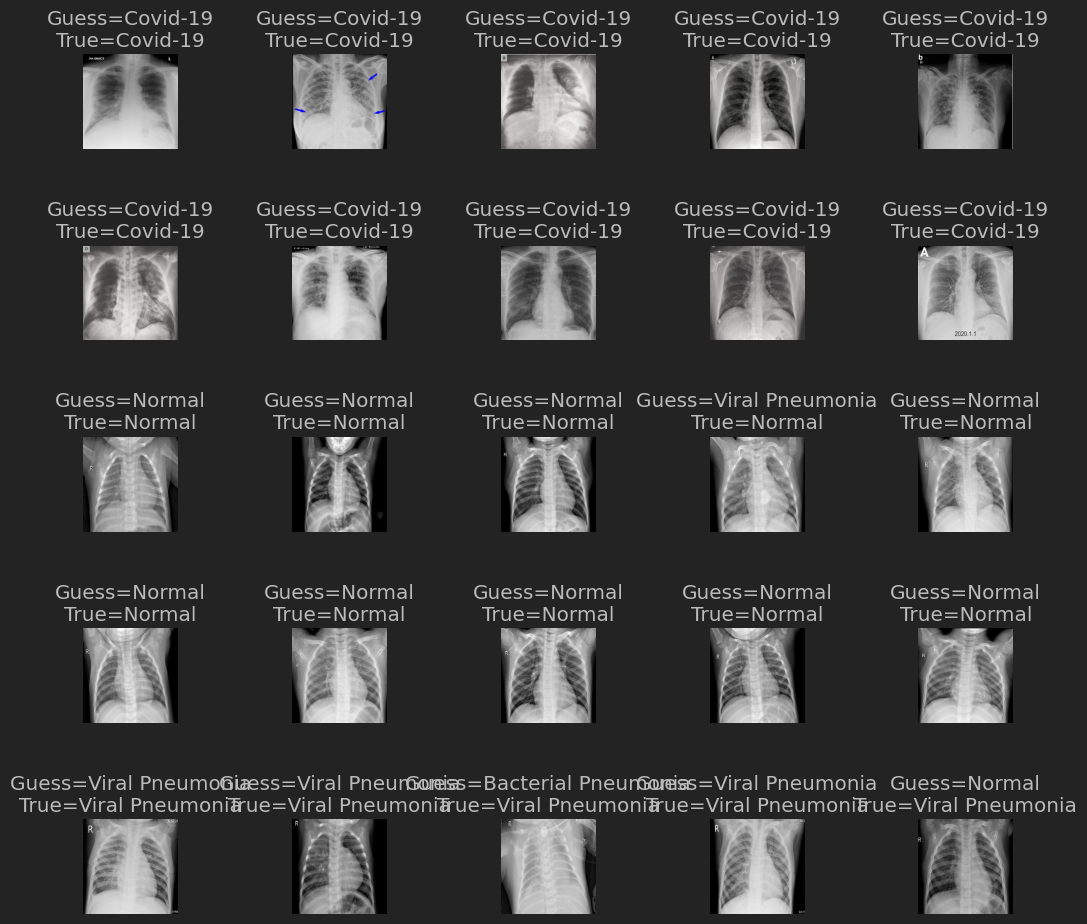

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [ ]:
print(classification_report(np.array(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.82      0.90      0.86        10
           2       0.67      0.60      0.63        10
           3       0.86      0.60      0.71        10

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



Text(0.5, 1.0, 'Confusion_matrix')

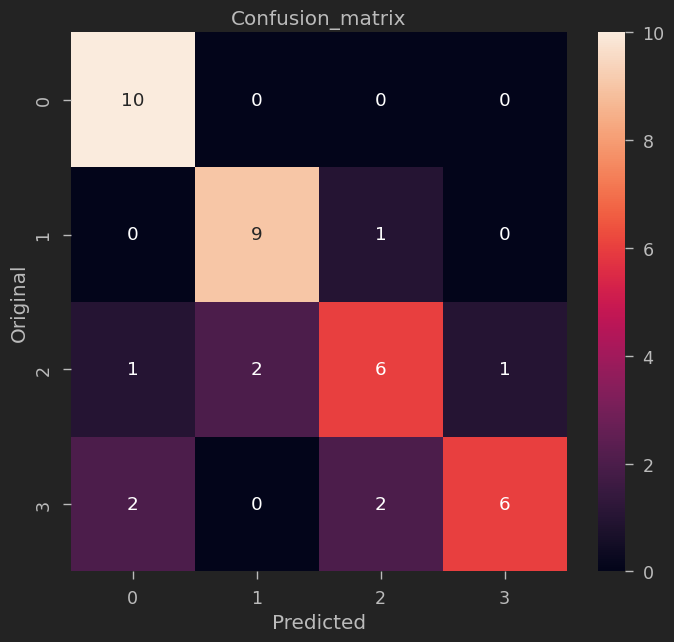

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')